In [1]:
# === BLOCCO 1 - IMPORT LIBRERIE ===
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import time
import seaborn as sns

# ML utils
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Classificatori
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron

# Deep learning
import tensorflow as tf
from tensorflow import keras

In [2]:
# ===============================================
# === BLOCCO 2 - LETTURA IMMAGINI E LABEL ===
# ===============================================

base_dir = Path('/Users/matteobraglia/Desktop/PROGETTO DATA/IndustryBiscuit/Images')
labels_csv = pd.read_csv('/Users/matteobraglia/Desktop/PROGETTO DATA/IndustryBiscuit/Annotations.csv')

file_to_class = dict(zip(labels_csv['file'], labels_csv['classCode']))

images, labels = [], []

for img_file in base_dir.glob("*.jpg"):
    try:
        img = Image.open(img_file).convert("RGB")
        images.append(np.array(img))
        labels.append(file_to_class[img_file.name])
    except Exception as e:
        print("Errore su", img_file, ":", e)

X = np.stack(images)
y = np.array(labels, dtype=np.int64)

class_mapping = dict(zip(labels_csv['classCode'], labels_csv['classDescription']))
num_classes = len(class_mapping)

print("Shape immagini:", X.shape)
print("Shape labels:", y.shape)
print("Classi:", class_mapping)

Shape immagini: (4900, 256, 256, 3)
Shape labels: (4900,)
Classi: {1: 'Defect_Shape', 2: 'Defect_Object', 3: 'Defect_Color', 0: 'Defect_No'}


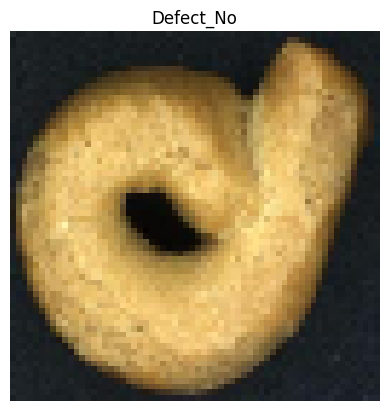

In [3]:
# ===============================================
# === BLOCCO 4 - RIDIMENSIONAMENTO A 64x64 ===
# ===============================================

def resize_to_64(img):
    h, w = img.shape[:2]
    y_idx = np.linspace(0, h-1, 64).round().astype(int)
    x_idx = np.linspace(0, w-1, 64).round().astype(int)
    return img[y_idx][:, x_idx]

X64 = np.stack([resize_to_64(im) for im in X])
X64 = X64.astype("float32") / 255

# Visualizza un esempio ridimensionato
id = 175
plt.imshow(X64[id])
plt.title(class_mapping[y[id]])
plt.axis('off')
plt.show()


In [4]:
# ===============================================
# === BLOCCO 5 - TRAIN/TEST SPLIT ===
# ===============================================

x_train, x_test, y_train, y_test = train_test_split(
    X64, y, test_size=0.2, random_state=42, stratify=y
)

print('Train shape:', x_train.shape, 'Test shape:', x_test.shape)

Train shape: (3920, 64, 64, 3) Test shape: (980, 64, 64, 3)


In [5]:
# ===============================================
# === BLOCCO 6 - PCA + ML CLASSICI (RGB) ===
# ===============================================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def fit_pca_features_rgb(X_train, n_components=100):
    N = X_train.shape[0]
    # Flattening mantenendo i 3 canali (R,G,B)
    X_flat = X_train.reshape(N, -1)
    # Standardizzazione
    scaler = StandardScaler().fit(X_flat)
    X_s = scaler.transform(X_flat)
    # PCA con n_components fissato a 100
    pca = PCA(n_components=n_components, random_state=42).fit(X_s)
    X_pca = pca.transform(X_s)
    return X_pca, scaler, pca

def transform_pca_features_rgb(X, scaler, pca):
    N = X.shape[0]
    X_flat = X.reshape(N, -1)
    X_s = scaler.transform(X_flat)
    return pca.transform(X_s)

# Esempio di utilizzo
X_train_feat, scaler, pca = fit_pca_features_rgb(x_train, n_components=100)
X_test_feat = transform_pca_features_rgb(x_test, scaler, pca)

print("Train features:", X_train_feat.shape)
print("Test features:", X_test_feat.shape)

# Helper valutazione
results = []

def evaluate_and_save(name, model, X_test_feat, y_test, y_pred, best_params=None, fit_time=None):
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    macro_prec = precision_score(y_test, y_pred, average='macro')
    macro_rec = recall_score(y_test, y_pred, average='macro')

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("F1-macro:", macro_f1)
    print("Precision-macro:", macro_prec)
    print("Recall-macro:", macro_rec)
    print("Best params:", best_params)

    results.append({
        "model": name,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "best_params": best_params,
        "fit_time_sec": fit_time
    })

def plot_cm(model_name, y_true, y_pred, class_mapping):
    labels = [class_mapping[i] for i in range(len(class_mapping))]
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Train features: (3920, 100)
Test features: (980, 100)



===== KNN =====
Accuracy: 0.7816326530612245
F1-macro: 0.7003358295714279
Precision-macro: 0.8322435315742938
Recall-macro: 0.6664263236630876
Best params: {'metric': 'euclidean', 'n_neighbors': 3}


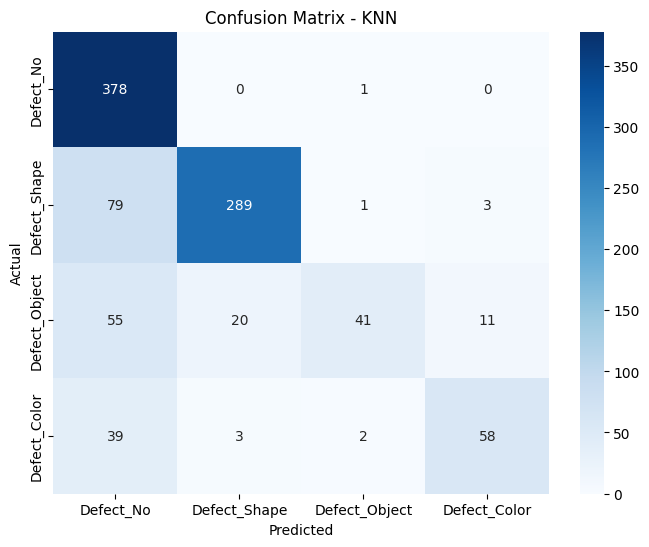

In [6]:
# ===== GridSearch + Modelli Classici =====
# KNN
param_grid = {"n_neighbors": [3,5,7], "metric": ["euclidean", "manhattan"]}
gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("KNN", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("KNN", y_test, y_pred, class_mapping)


===== DecisionTree =====
Accuracy: 0.8071428571428572
F1-macro: 0.7634215751528337
Precision-macro: 0.7862993532477258
Recall-macro: 0.7483760874901852
Best params: {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 10}


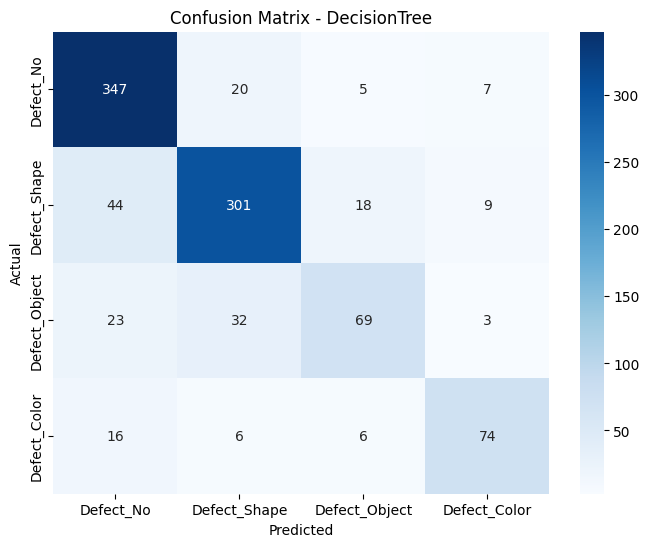

In [8]:
# DecisionTree
param_grid = {"criterion": ["gini","entropy"], "max_depth": [None,5,10,20], "ccp_alpha": [0.0,0.001,0.005]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("DecisionTree", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("DecisionTree", y_test, y_pred, class_mapping)


===== LogisticRegression =====
Accuracy: 0.75
F1-macro: 0.6854684616812377
Precision-macro: 0.7160725163818367
Recall-macro: 0.669007388314844
Best params: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


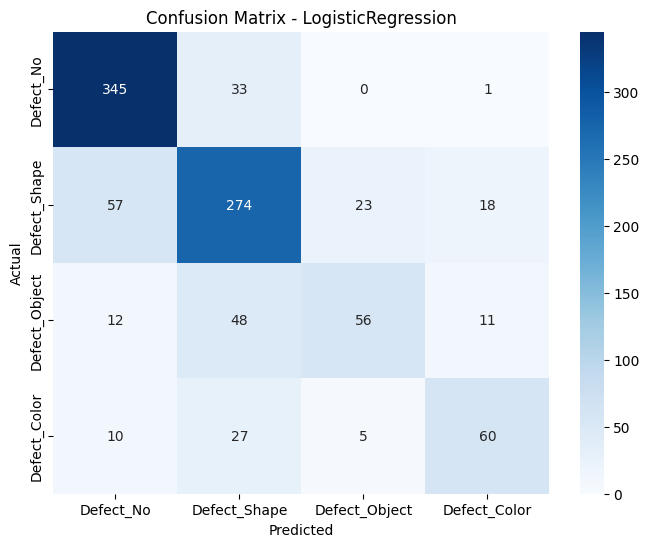

In [9]:
# LogisticRegression
param_grid = {"C":[0.1,1,10], "solver":["lbfgs"], "penalty":["l2"], "max_iter":[1000]}
gs = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("LogisticRegression", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("LogisticRegression", y_test, y_pred, class_mapping)


===== Perceptron =====
Accuracy: 0.6224489795918368
F1-macro: 0.5442008983594828
Precision-macro: 0.5414018900035585
Recall-macro: 0.5498529521491243
Best params: {'alpha': 0.0001, 'max_iter': 1000, 'penalty': None}


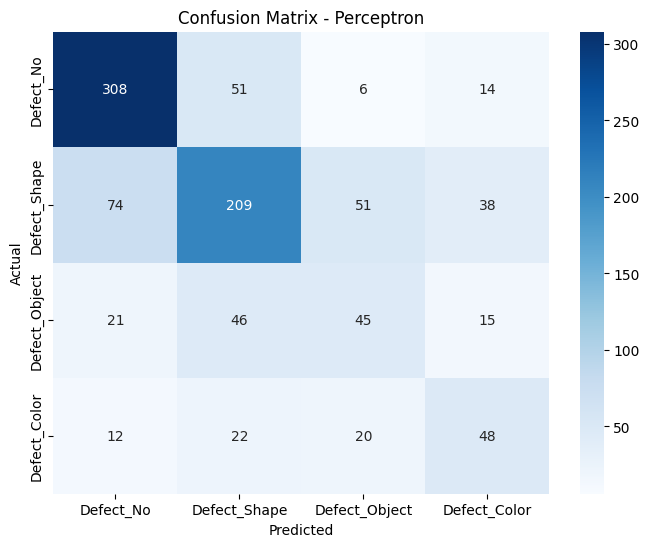

In [10]:
# Perceptron
param_grid = {"alpha":[1e-4,1e-3,1e-2], "penalty":[None,"l2"], "max_iter":[1000]}
gs = GridSearchCV(Perceptron(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
t0 = time.time()
gs.fit(X_train_feat, y_train)
t1 = time.time()
y_pred = gs.best_estimator_.predict(X_test_feat)
evaluate_and_save("Perceptron", gs.best_estimator_, X_test_feat, y_test, y_pred, gs.best_params_, t1-t0)

plot_cm("Perceptron", y_test, y_pred, class_mapping)

In [11]:
# Risultati finali modelli classici
df_results = pd.DataFrame(results).sort_values("accuracy", ascending=False)
print("\n===== RISULTATI CLASSICI =====")
print(df_results.to_string(index=False))


===== RISULTATI CLASSICI =====
             model  accuracy  macro_f1  macro_precision  macro_recall                                                    best_params  fit_time_sec
      DecisionTree  0.807143  0.763422         0.786299      0.748376     {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 10}     18.159470
               KNN  0.781633  0.700336         0.832244      0.666426                      {'metric': 'euclidean', 'n_neighbors': 3}      5.452852
LogisticRegression  0.750000  0.685468         0.716073      0.669007 {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}      2.281616
        Perceptron  0.622449  0.544201         0.541402      0.549853           {'alpha': 0.0001, 'max_iter': 1000, 'penalty': None}      0.831769


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,676 (1018.27 KB)

 Trainable params: 260,676 (1018.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.4461 - loss: 1.1400 - val_accuracy: 0.5931 - val_loss: 0.9097
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.6173 - loss: 0.8635 - val_accuracy: 0.7806 - val_loss: 0.6007
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7889 - loss: 0.5942 - val_accuracy: 0.8214 - val_loss: 0.4839
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8320 - loss: 0.5161 - val_accuracy: 0.8890 - val_loss: 0.3115
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8862 - loss: 0.3822 - val_accuracy: 0.8852 - val_loss: 0.3069
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.8983 - loss: 0.3433 - val_accuracy: 0.9209 - val_loss: 0.2501
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9002 - loss: 0.3383 - val_accuracy: 0.8635 - val_loss: 0.3434
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9133 - loss: 0.2812 - val_accuracy: 0.9145 - v

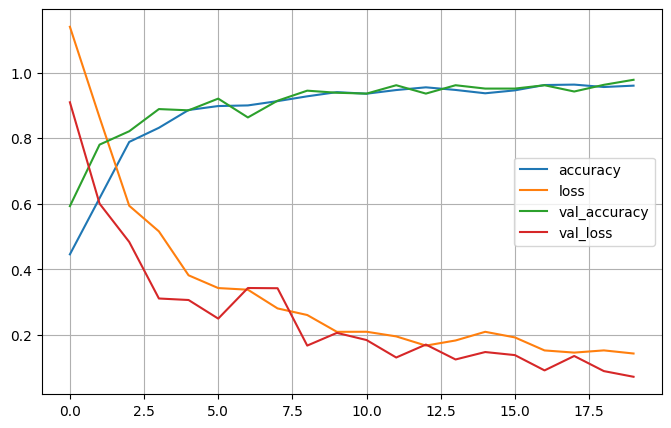

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step


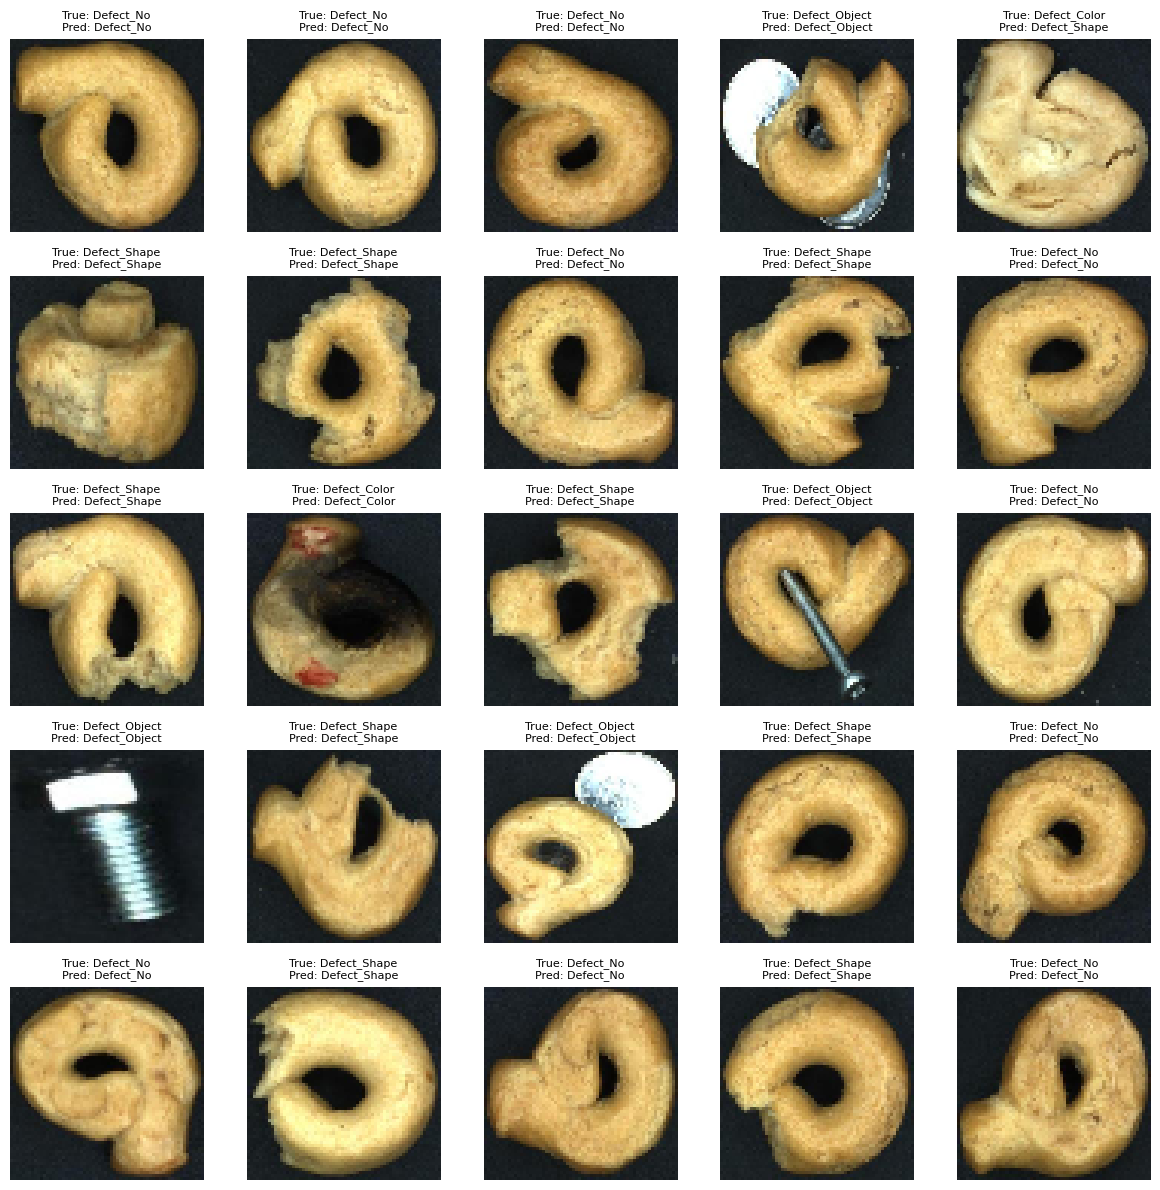

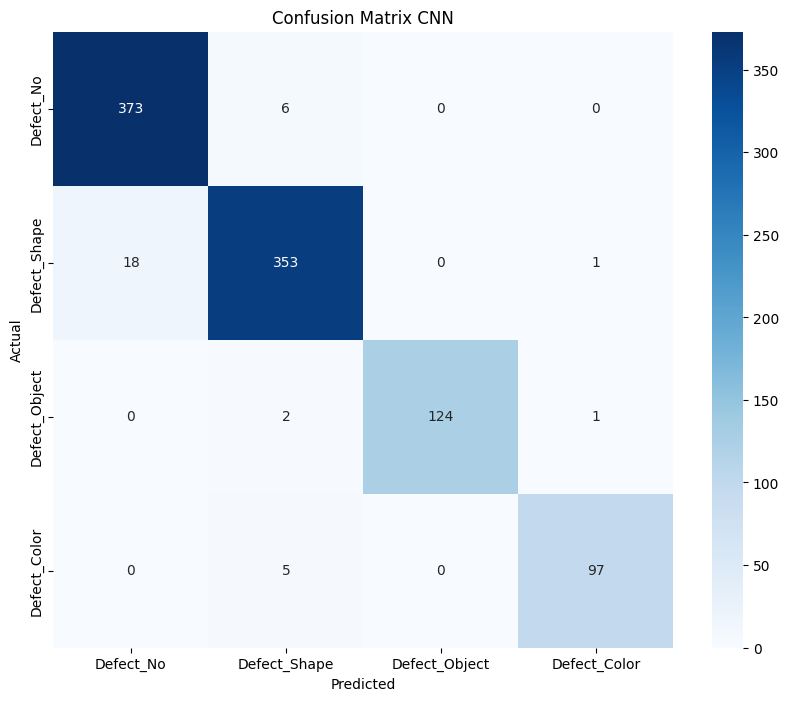

In [12]:
# ===============================================
# === BLOCCO 7 - CNN ===
# ===============================================

input_shape = (64,64,3)
model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(x_train, y_train, epochs=20, validation_split=0.2, callbacks=callbacks)

# Storia training
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

# Predict
predictions = model.predict(x_test)
cpredictions = [np.argmax(p) for p in predictions]

# Griglia immagini predizioni
plt.figure(figsize=(12,12))
for i in range(1,26):
    img = x_test[-i]
    plt.subplot(5,5,i)
    plt.imshow(img)
    plt.title(f"True: {class_mapping[y_test[-i]]}\nPred: {class_mapping[cpredictions[-i]]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion matrix CNN
label_names = [class_mapping[i] for i in range(num_classes)]
cm = confusion_matrix(y_test, cpredictions)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CNN')
plt.show()